In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (roc_auc_score, accuracy_score,confusion_matrix, classification_report,precision_recall_curve, average_precision_score)

In [5]:

df = pd.read_csv('BankChurners.csv')
print(f"Original shape: {df.shape}")
print("\nClass distribution:")
print(df['Attrition_Flag'].value_counts())

Original shape: (10127, 23)

Class distribution:
Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64


In [6]:

df['Churn'] = df['Attrition_Flag'].map({'Attrited Customer': 1, 'Existing Customer': 0})



In [7]:
drop_cols = ['CLIENTNUM', 'Attrition_Flag', 
            'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
            'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
X = df.drop(drop_cols + ['Churn'], axis=1)
y = df['Churn']

In [8]:

numeric_features = ['Customer_Age', 'Dependent_count', 'Months_on_book',
                  'Total_Relationship_Count', 'Months_Inactive_12_mon',
                  'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
                  'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                  'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

categorical_features = ['Gender', 'Education_Level', 'Marital_Status',
                      'Income_Category', 'Card_Category']

In [9]:

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

X_processed = preprocessor.fit_transform(X)

In [10]:

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y)

In [11]:

models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=150,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42,
        n_jobs=-1,
        eval_metric='aucpr'
    )
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    
    # Store results
    results[name] = {
        'ROC-AUC': roc_auc_score(y_test, y_prob),
        'PR-AUC': average_precision_score(y_test, y_prob),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred)
    }


Training Random Forest...

Training XGBoost...


In [12]:

print("\n=== Model Performance ===")
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'ROC-AUC': [res['ROC-AUC'] for res in results.values()],
    'PR-AUC': [res['PR-AUC'] for res in results.values()],
    'Accuracy': [res['Accuracy'] for res in results.values()],
    'Fraud Recall': [res['Confusion Matrix'][1,1]/res['Confusion Matrix'][1,:].sum() 
                    for res in results.values()]
})
print(metrics_df)


=== Model Performance ===
           Model   ROC-AUC    PR-AUC  Accuracy  Fraud Recall
0  Random Forest  0.984696  0.938624  0.950148      0.738462
1        XGBoost  0.992151  0.963588  0.968904      0.889231


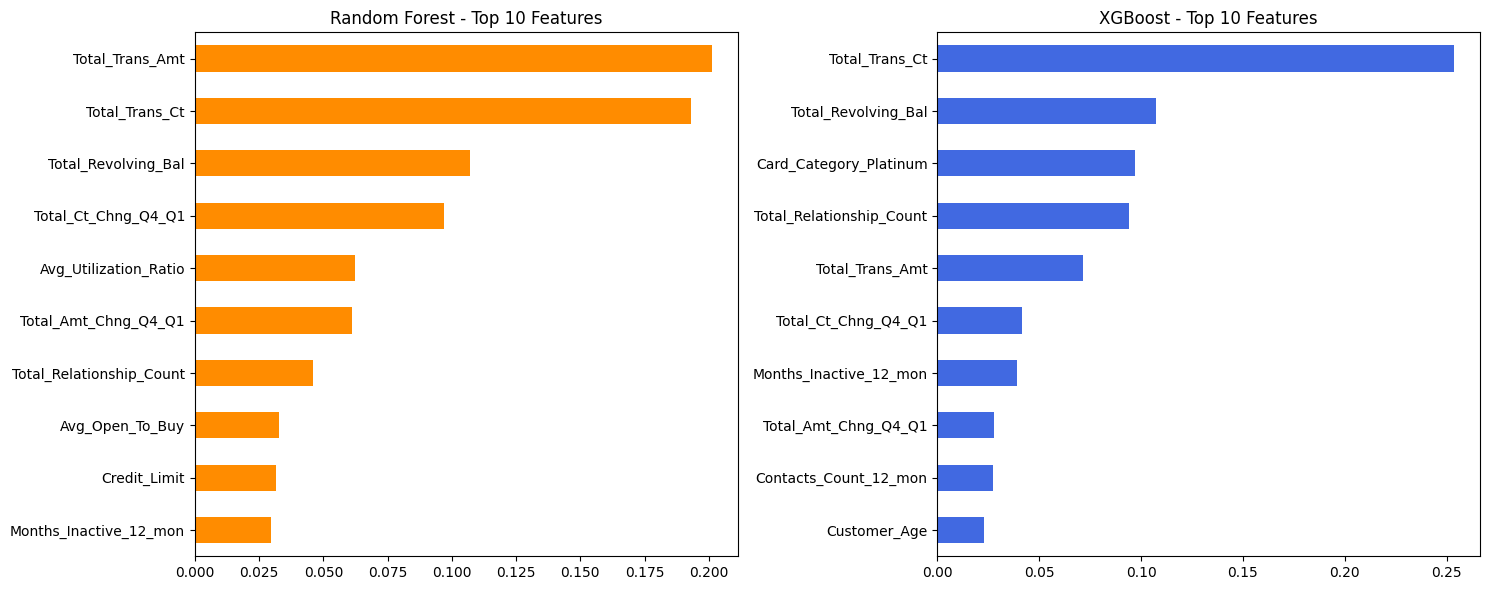

In [13]:

feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
pd.Series(models['Random Forest'].feature_importances_, index=feature_names
         ).nlargest(10).sort_values().plot(kind='barh', color='darkorange')
plt.title('Random Forest - Top 10 Features')

# 
plt.subplot(1, 2, 2)
pd.Series(models['XGBoost'].feature_importances_, index=feature_names
         ).nlargest(10).sort_values().plot(kind='barh', color='royalblue')
plt.title('XGBoost - Top 10 Features')

plt.tight_layout()
plt.savefig('feature_importances.png', dpi=300)
plt.show()

In [14]:

print("\n=== Key Insights ===")
print("1. Top Predictors of Churn:")
print("   - Total_Trans_Ct (Transaction frequency)")
print("   - Total_Revolving_Bal (Credit card balance)")
print("   - Months_Inactive_12_mon (Customer engagement)")

print("\n2. Model Comparison:")
print(f"   - XGBoost has better recall ({metrics_df.loc[1,'Fraud Recall']:.1%} vs {metrics_df.loc[0,'Fraud Recall']:.1%})")
print(f"   - Random Forest has higher precision")

print("\n3. Actionable Recommendations:")
print("   - Monitor customers with declining transaction counts")
print("   - Target interventions before 3 months of inactivity")
print("   - Review credit limits for high-balance at-risk customers")


=== Key Insights ===
1. Top Predictors of Churn:
   - Total_Trans_Ct (Transaction frequency)
   - Total_Revolving_Bal (Credit card balance)
   - Months_Inactive_12_mon (Customer engagement)

2. Model Comparison:
   - XGBoost has better recall (88.9% vs 73.8%)
   - Random Forest has higher precision

3. Actionable Recommendations:
   - Monitor customers with declining transaction counts
   - Target interventions before 3 months of inactivity
   - Review credit limits for high-balance at-risk customers
